In [2]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)

from tqdm import tqdm

from src.utils import CIFAR
from src.model import CIFAR_CNN

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [3]:

def stochastic_gradient_sampling(model, optimizer, train_loader, criterion, device):
    model.train()
    full_gradients = {name: 0 for name, param in model.named_parameters()}
    
    # Первый цикл: вычисляем полные градиенты (усредненные по батчам)
    for images, labels in tqdm(train_loader, desc="Computing full gradients"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        for name, param in model.named_parameters():
            full_gradients[name] += param.grad
    
    # Усредняем полные градиенты по количеству батчей
    for name in full_gradients:
        full_gradients[name] /= len(train_loader)
    
    # Второй цикл: вычисляем разности с полными градиентами и сохраняем 2-норму
    gradients_diff = []
    for images, labels in tqdm(train_loader, desc="Computing gradient differences"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Для каждого батча считаем разницу в норме между полными и стохастическими градиентами
        gradient_diff = {name: (full_gradients[name] - param.grad).norm(p=2).item()
                         for name, param in model.named_parameters()}
        
        gradients_diff.append(gradient_diff)
    
    return gradients_diff


In [4]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp6"


In [5]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]

# Список для хранения моделей
models = []

# Загружаем модели
for checkpoint_file in checkpoint_files:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_file)
    
    # Создаём экземпляр модели
    model = CIFAR_CNN().to(DEVICE)
    
    # Загружаем веса модели
    model.load_state_dict(torch.load(checkpoint_path))
    
    # Добавляем модель в список
    models.append(model)
    print(f"Model loaded from {checkpoint_path}")

Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_20.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_4.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_8.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_16.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_12.pth


In [27]:
batch_sizes = [ 1, 4, 16, 64]
train_loader, test_loader = {}, {}

all_gradients_diff = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    print(f"\nProcessing batch_size = {batch_size}")
    
    train_dataset, test_dataset, train_loader[batch_size], test_loader[batch_size] = CIFAR(batch_size=batch_size)
    
    for i, model in enumerate(models):
        print(f"Processing model {i+1}/{len(models)} for batch_size {batch_size}")
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # Пример оптимизатора
        criterion = torch.nn.CrossEntropyLoss()  # Пример критерия
        
        gradients_diff = stochastic_gradient_sampling(model, optimizer, train_loader[batch_size], criterion, DEVICE)
        
        all_gradients_diff[batch_size].append(gradients_diff)


Processing batch_size = 1
Processing model 1/5 for batch_size 1


Computing gradient differences: 100%|██████████| 50000/50000 [12:37<00:00, 66.02it/s]


Processing model 2/5 for batch_size 1


Computing gradient differences: 100%|██████████| 50000/50000 [11:40<00:00, 71.40it/s]


Processing model 3/5 for batch_size 1


Computing gradient differences: 100%|██████████| 50000/50000 [12:12<00:00, 68.25it/s]


Processing model 4/5 for batch_size 1


Computing gradient differences: 100%|██████████| 50000/50000 [12:20<00:00, 67.51it/s]


Processing model 5/5 for batch_size 1


Computing gradient differences: 100%|██████████| 50000/50000 [13:17<00:00, 62.66it/s]



Processing batch_size = 4
Processing model 1/5 for batch_size 4


Computing gradient differences: 100%|██████████| 12500/12500 [03:37<00:00, 57.40it/s]


Processing model 2/5 for batch_size 4


Computing gradient differences: 100%|██████████| 12500/12500 [03:36<00:00, 57.70it/s]


Processing model 3/5 for batch_size 4


Computing gradient differences: 100%|██████████| 12500/12500 [03:21<00:00, 62.08it/s]


Processing model 4/5 for batch_size 4


Computing gradient differences: 100%|██████████| 12500/12500 [03:29<00:00, 59.53it/s]


Processing model 5/5 for batch_size 4


Computing gradient differences: 100%|██████████| 12500/12500 [03:35<00:00, 58.06it/s]



Processing batch_size = 16
Processing model 1/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:51<00:00, 61.01it/s]


Processing model 2/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:52<00:00, 59.97it/s]


Processing model 3/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:51<00:00, 61.20it/s]


Processing model 4/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:51<00:00, 61.21it/s]


Processing model 5/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:50<00:00, 61.33it/s]



Processing batch_size = 64
Processing model 1/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:20<00:00, 38.63it/s]


Processing model 2/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:20<00:00, 38.42it/s]


Processing model 3/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:20<00:00, 38.52it/s]


Processing model 4/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:20<00:00, 38.45it/s]


Processing model 5/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:20<00:00, 38.47it/s]


In [28]:
num_checkpoints = 5


50000
12500
3125
782


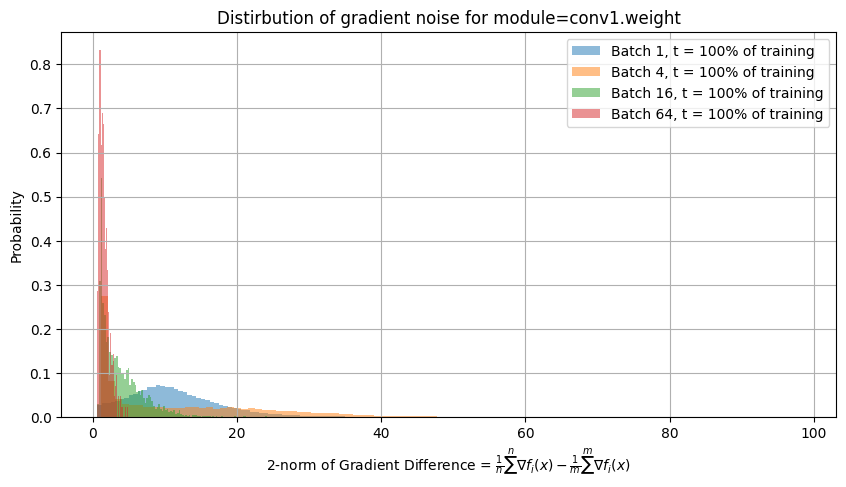

50000
12500
3125
782


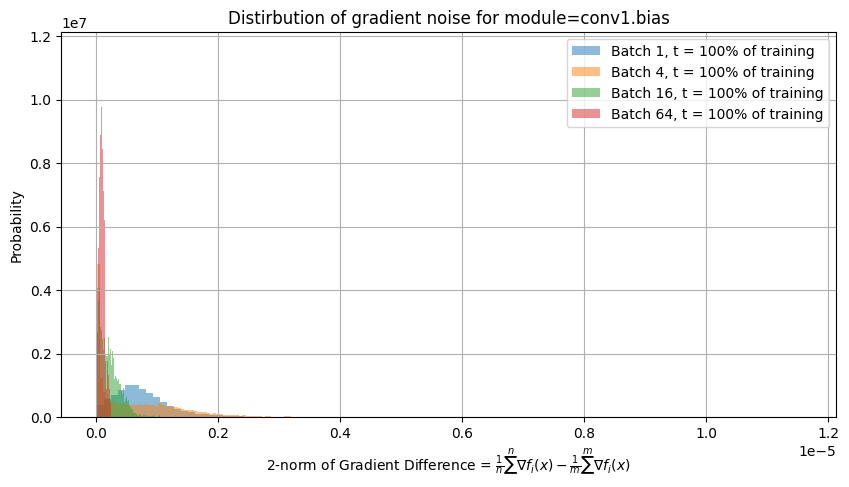

50000
12500
3125
782


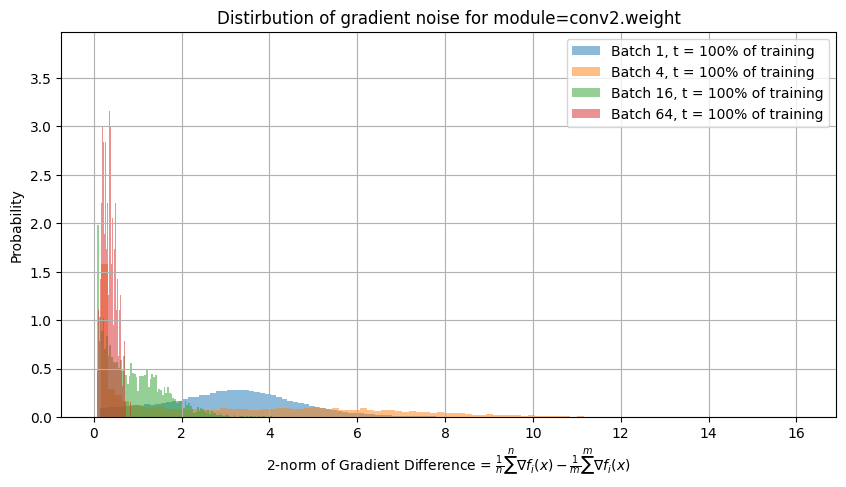

50000
12500
3125
782


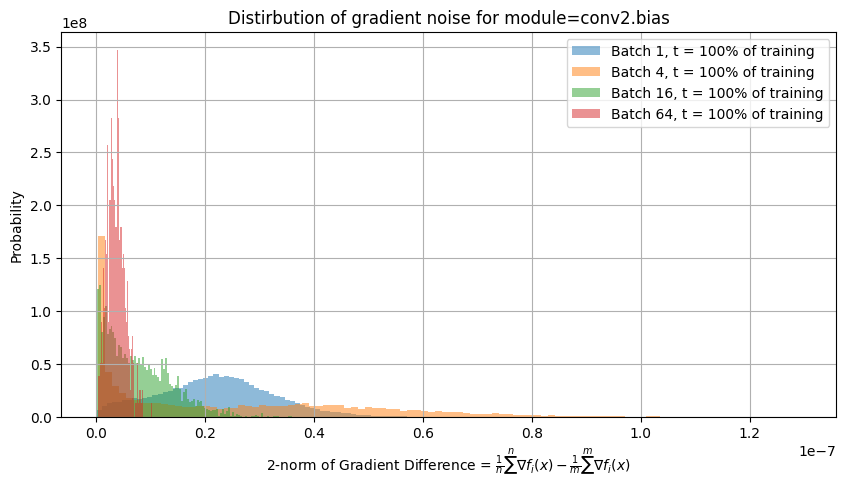

50000
12500
3125
782


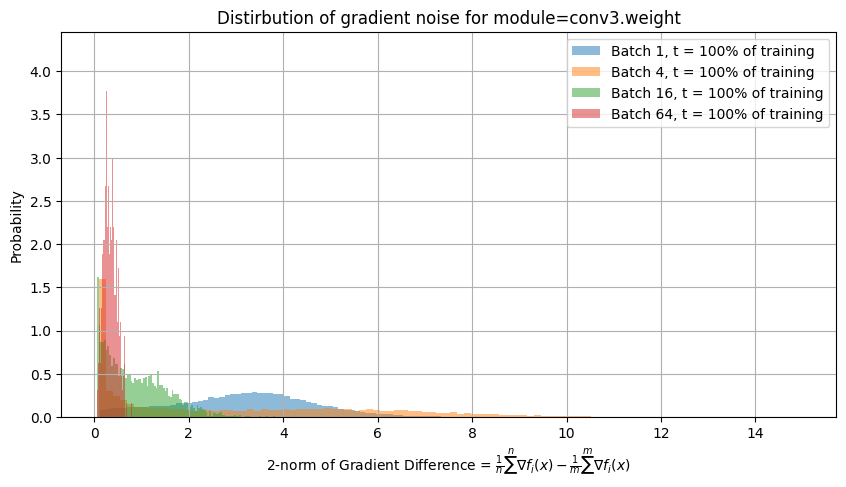

50000
12500
3125
782


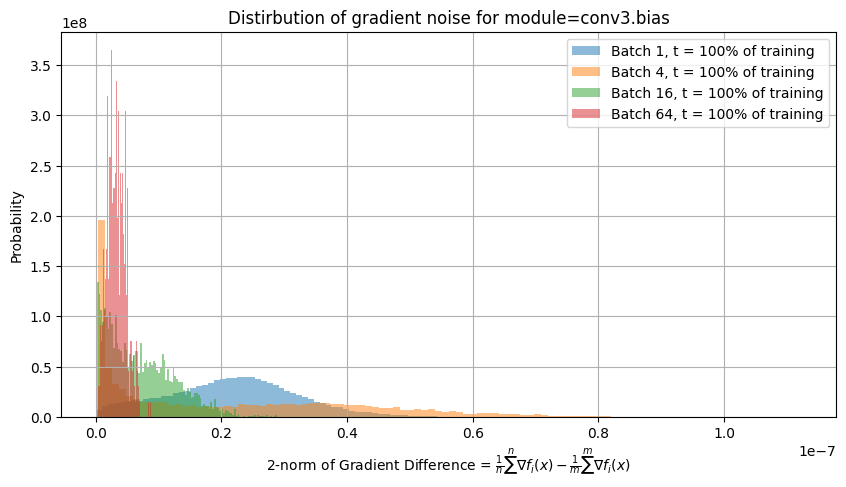

50000
12500
3125
782


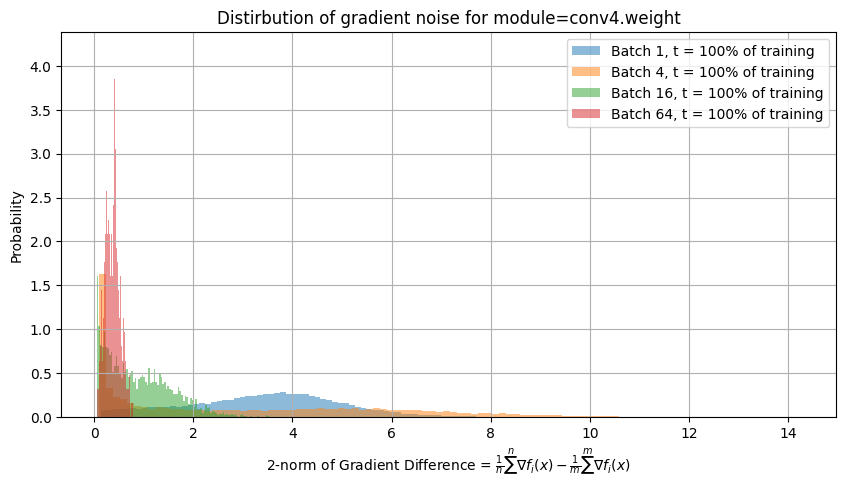

50000
12500
3125
782


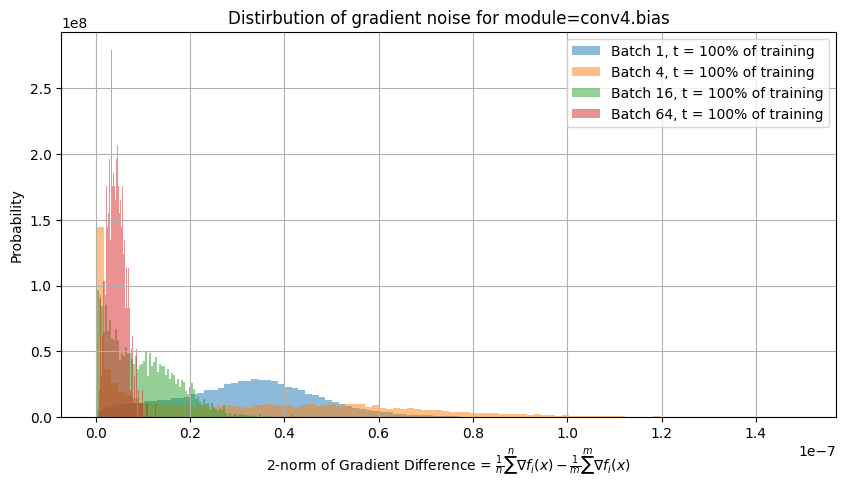

50000
12500
3125
782


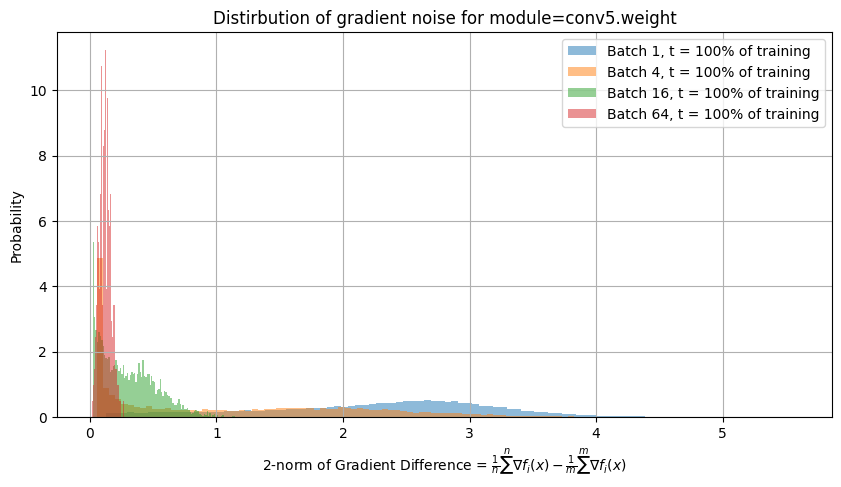

50000
12500
3125
782


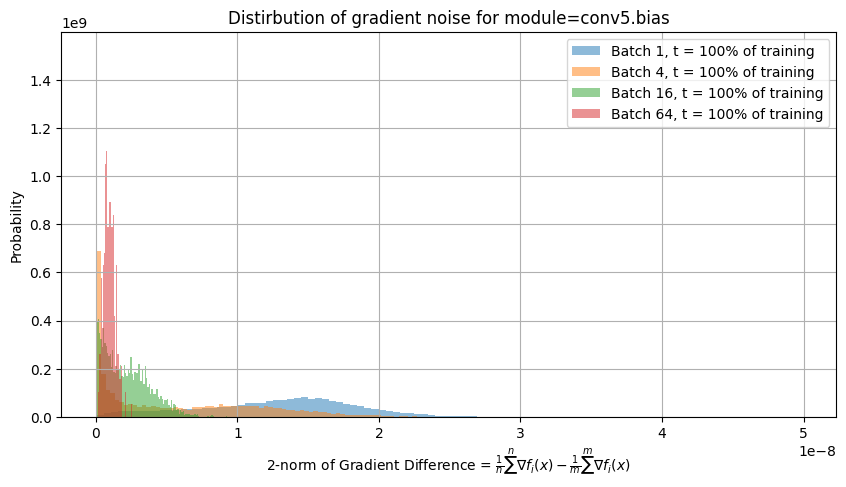

50000
12500
3125
782


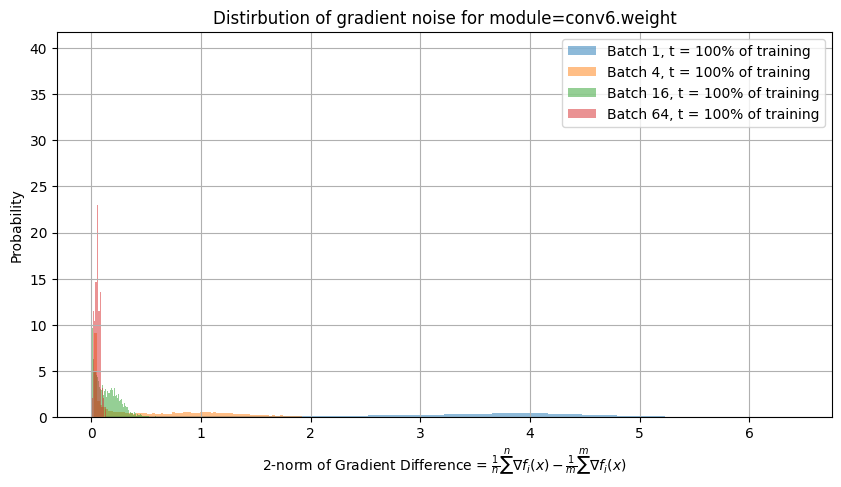

50000
12500
3125
782


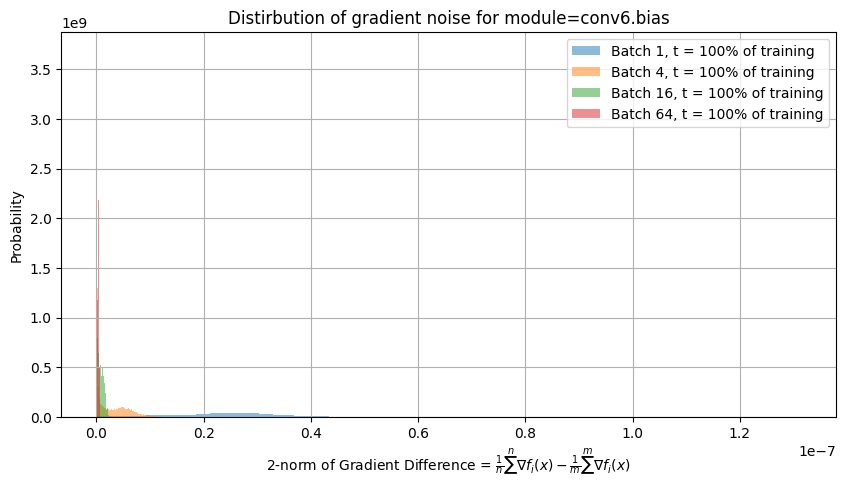

50000
12500
3125
782


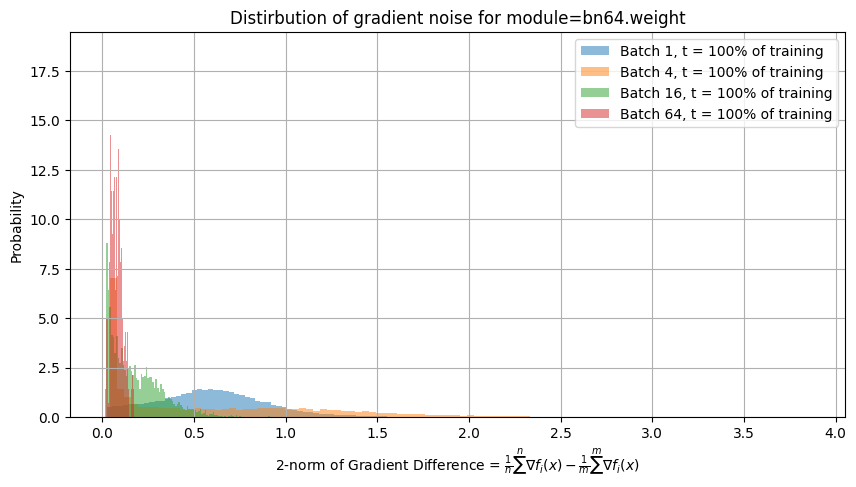

50000
12500
3125
782


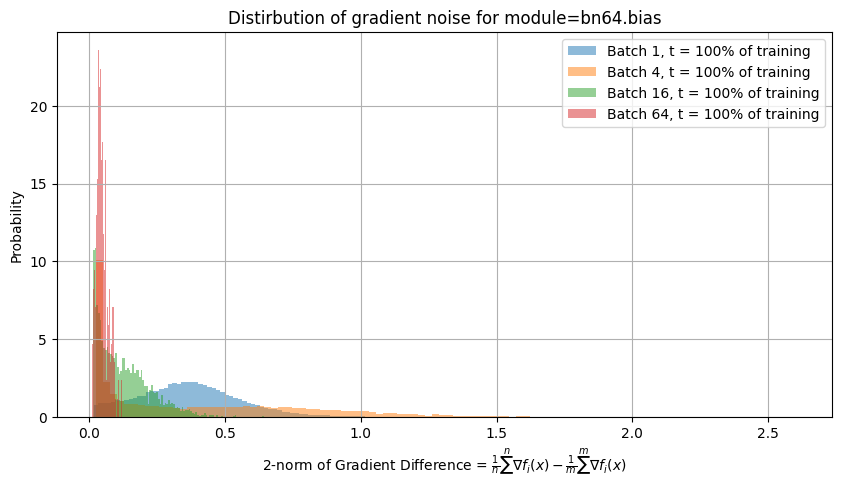

50000
12500
3125
782


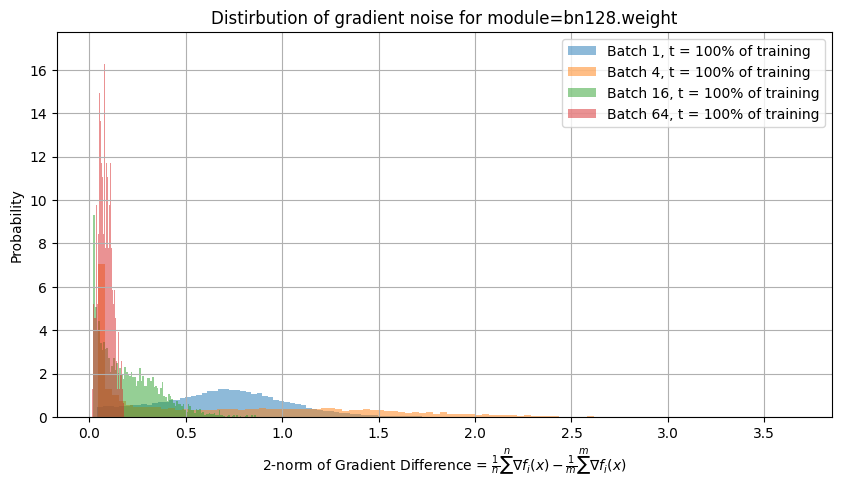

50000
12500
3125
782


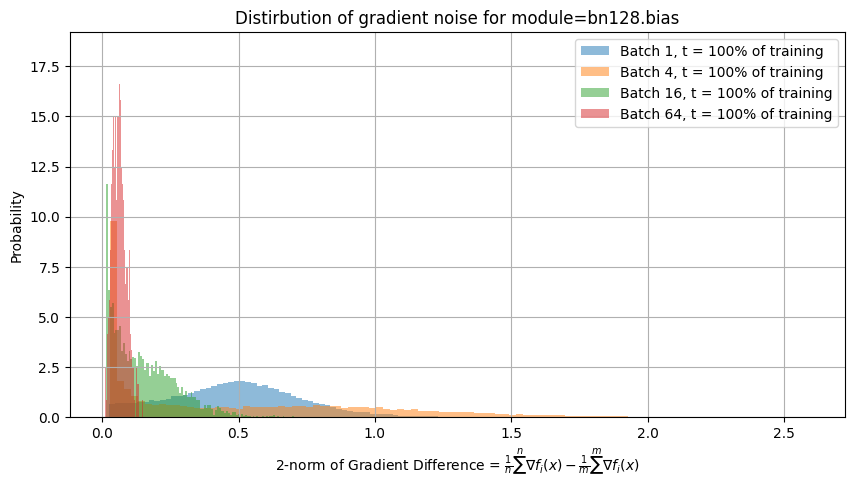

50000
12500
3125
782


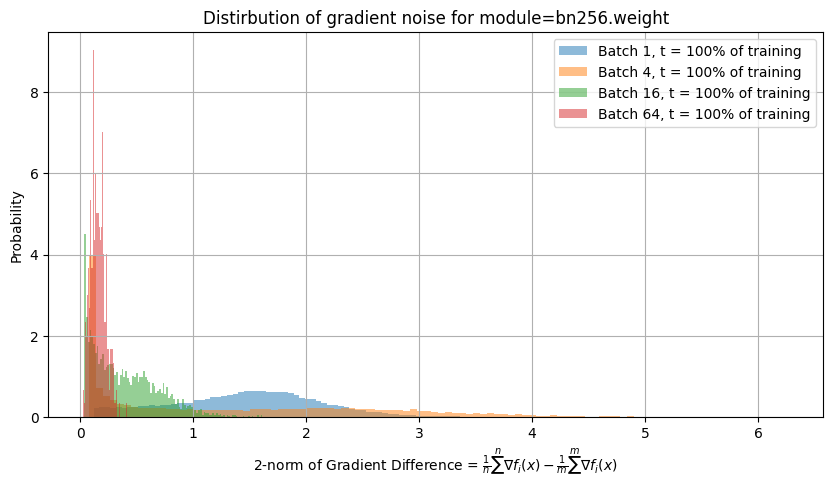

50000
12500
3125
782


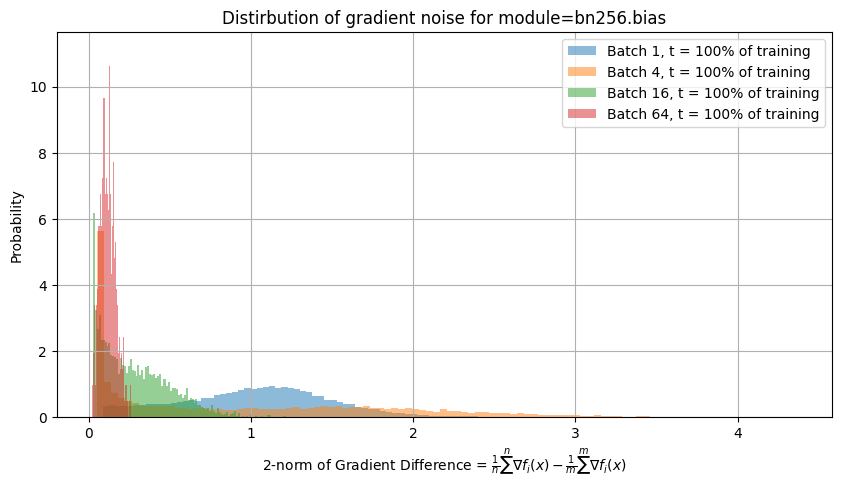

50000
12500
3125
782


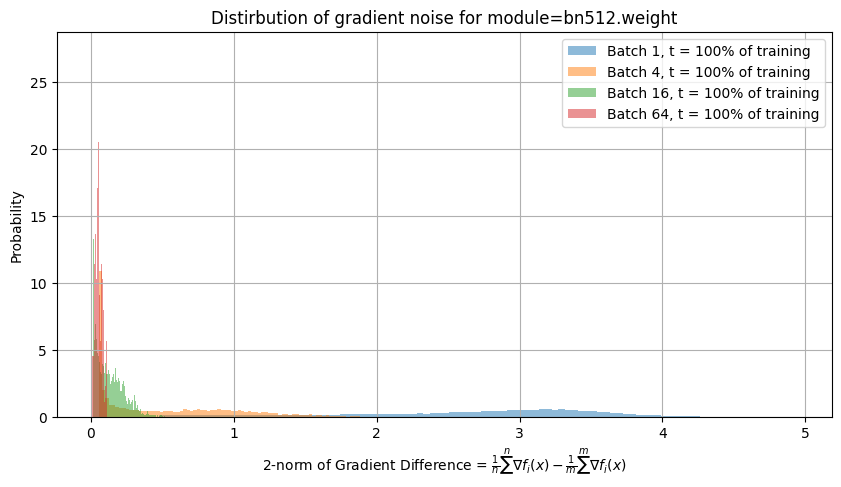

50000
12500
3125
782


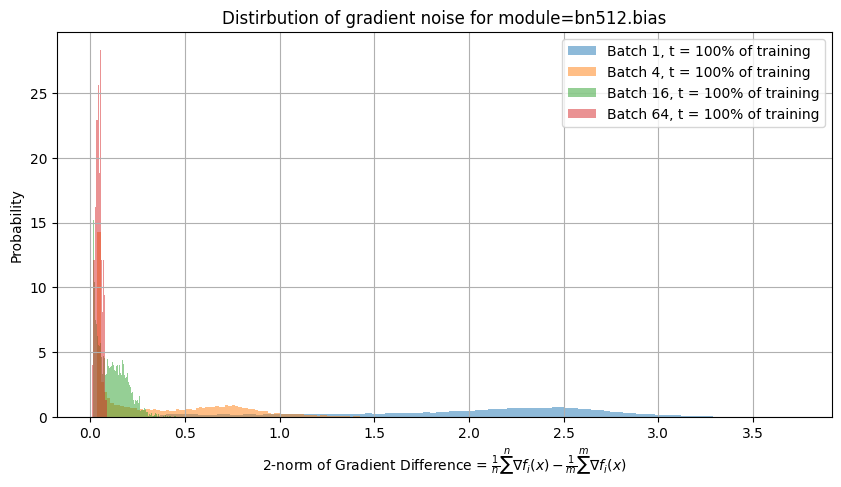

50000
12500
3125
782


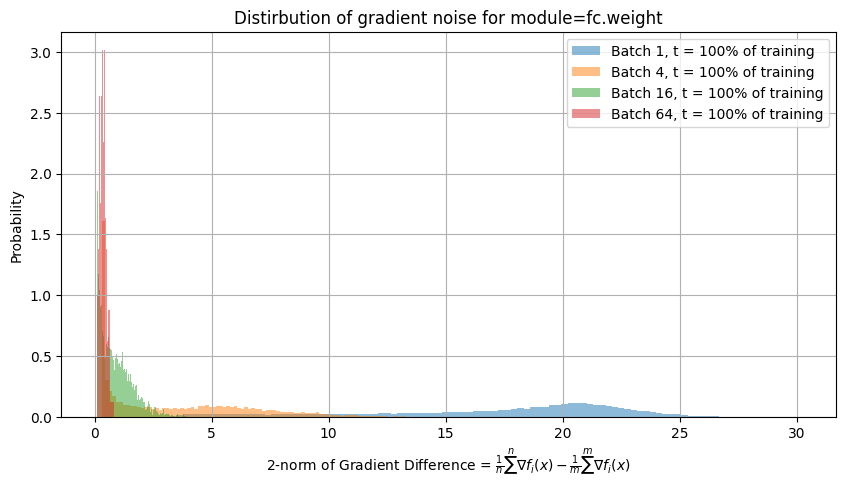

50000
12500
3125
782


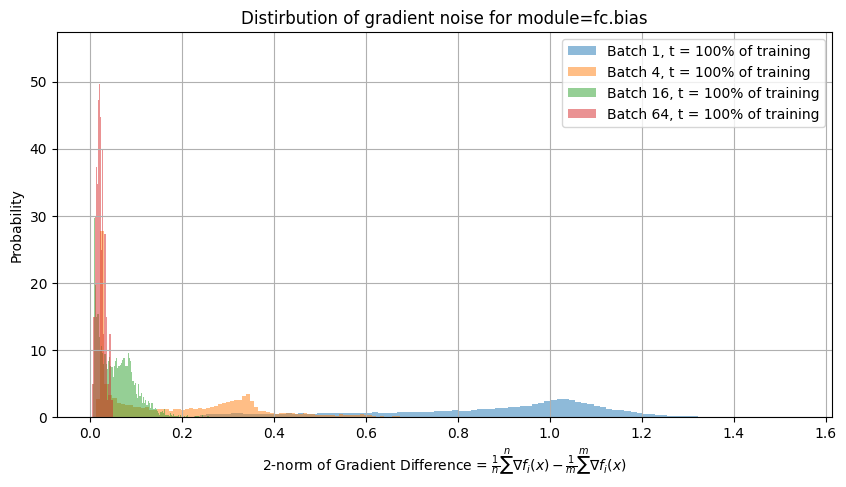

In [40]:
for key, _ in model.named_parameters():
    plt.figure(figsize=(10, 5))

    for batch_size in batch_sizes[:4]:
        for checkpoint_idx in range(len(all_gradients_diff[batch_size]))[-1:]:
            values = [ v[key] for v in all_gradients_diff[batch_size][checkpoint_idx] ]
            print(len(values))
            plt.hist(values, bins=100,density=True, alpha=0.5, label=f'Batch {batch_size}, t = {int(100 * (checkpoint_idx + 1)/num_checkpoints)}% of training')
                    
    # Добавляем описание и отображаем график
    plt.xlabel(r'2-norm of Gradient Difference = $\frac{1}{n} \sum^n \nabla f_i(x) - \frac{1}{m} \sum^m \nabla f_i(x)$')
    plt.ylabel('Probability')
    plt.title(f'Distirbution of gradient noise for module={key}')
    plt.legend()
    plt.grid(True)
    plt.show()



In [41]:
import pickle
# Сохраняем список в файл
with open(f"{CHECKPOINT_DIR}/exp6.pkl", "wb") as f:
    pickle.dump(all_gradients_diff, f)